# Comprendre et maitriser le procédé et le système de mesure

La description physique du procédé est disponible au niveau de chaque poste de travail. Le capteur permet de mesurer une des grandeurs caractéristiques de son état. L’actionneur permet de modifier cet état. Le lien entre ces éléments et la station de travail est réalisé par la chaîne de mesure et de commande. Elle est principalement constituée de conditionneurs de signaux, et de convertisseurs analogiques-numériques et numériques-analogiques.

Observez le procédé (sans le mettre en route pour le moment) et repérez les divers éléments décrits sur le schéma, afin de comprendre son fonctionnement.

## Équation de calibration

À partir des valeurs de référence de la gamme de mesure du capteur, déterminez son équation linéaire de calibration (calibration à 2 points) de type :
$$y_{(grandeur\>physique)} =a \times u_{(tension\> capteur)} + b$$

In [1]:
% Calculez les coefficients a et b de ce polynôme du premier degré. Vous pouvez utiliser pour cela la fonction polyfit
U = [3,8]; % V
T = [15,40]; % °C
p = polyfit(U,T,1);
a = p(1);
b = p(2);

In [2]:
% Affichage de l'équation de calibration
% Indiquez l'unité de la grandeur physique y
printf('y (°C) = %.3g x u (V) %+.3g\n', a, b);

y (°C) = 5 x u (V) +0


## Incertitudes de mesure

In [3]:
ymin = -270; % °C
ymax = 400; % °C
Dyr = 0.025/100;

Dya = (ymax-ymin)*Dyr; %°C

cmin = 0; %V
cmax= 10; %V
N = 12; % bits

Dyn = (cmax-cmin)/(2^N-1); % V
Dyn = p(1)*Dyn; % °C

Dytot = Dya + Dyn; % °C

In [4]:
printf('Dya = %.2g °C\n', Dya)
printf('Dyn = %.2g °C\n', Dyn)
printf('Dytot = %.2g °C\n', Dytot)

Dya = 0.17 °C
Dyn = 0.012 °C
Dytot = 0.18 °C


# Extraire et caractériser le bruit de mesure

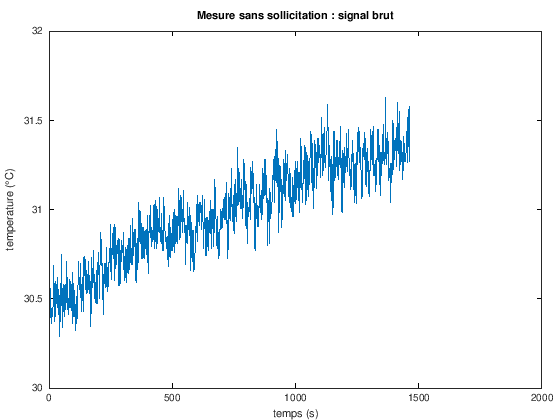

In [3]:
data = load('sanssollicitation.txt');
t = data(:,1);
y = data(:,6);
plot(t,y)
title('Mesure sans sollicitation : signal brut')
xlabel('temps (s)')
ylabel('temperature (\degC)')

## Prétraitement du signal de mesure

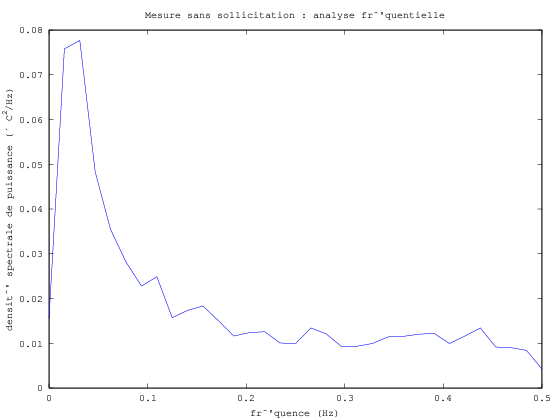

In [120]:
pwelch(y,[],[],[],1,'linear')
title('Mesure sans sollicitation : analyse fréquentielle')
xlabel('fréquence (Hz)')
ylabel('densité spectrale de puissance (°C^2/Hz)')

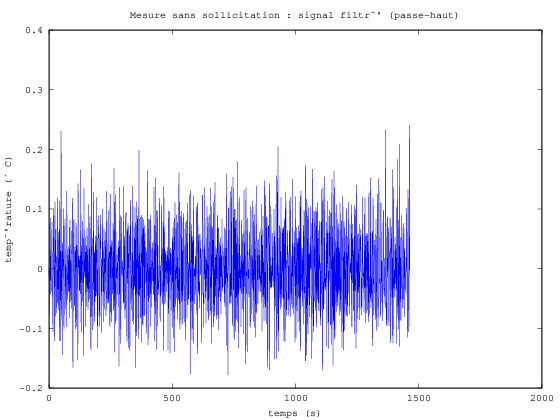

In [121]:
fc = 0.1; % Hz
[B,A] = butter(8,fc/0.5,'high');

yf = filtfilt(B,A,y);
plot(t,yf)
title('Mesure sans sollicitation : signal filtré (passe-haut)')
xlabel('temps (s)')
ylabel('température (°C)')

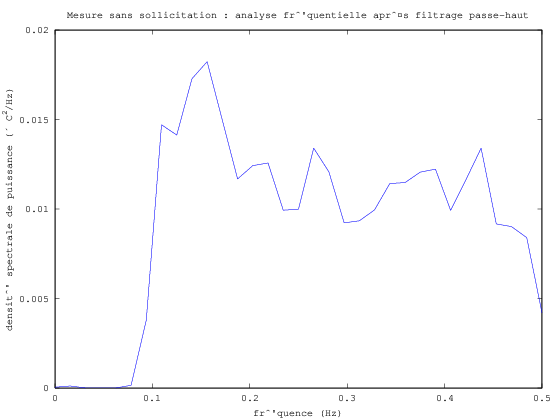

In [122]:
pwelch(yf,[],[],[],1,'linear')
title('Mesure sans sollicitation : analyse fréquentielle après filtrage passe-haut')
xlabel('fréquence (Hz)')
ylabel('densité spectrale de puissance (°C^2/Hz)')

## Caractérisation du bruit de mesure

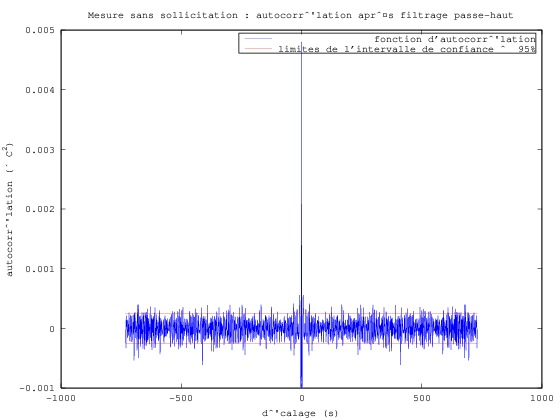

In [123]:
[c,lags] = xcov(yf,floor(length(yf)/2),'unbiased');
limc = 2*var(yf)/sqrt(length(yf));
plot(lags,c, [min(lags) max(lags)],[limc limc],'r', [min(lags) max(lags)],-[limc limc],'r')
title('Mesure sans sollicitation : autocorrélation après filtrage passe-haut')
xlabel('décalage (s)')
ylabel('autocorrélation (°C^2)')
legend('fonction d''autocorrélation', 'limites de l''intervalle de confiance à 95%')

In [124]:
miny = min(yf);
maxy = max(yf);
muy = mean(yf);
sigma2y = var(yf);
sigmay = std(yf);

In [125]:
printf('min = %.3g °C\n', miny)
printf('max = %.3g °C\n', maxy)
printf('moyenne = %.3g °C\n', muy)
printf('variance = %.3g °C²\n', sigma2y)
printf('écart-type = %.3g °C\n', sigmay)

min = -0.179 °C
max = 0.241 °C
moyenne = 8.75e-05 °C
variance = 0.0048 °C²
écart-type = 0.0693 °C


In [126]:
N1sigma = 100*length(find(yf<=muy+sigmay & yf>=muy-sigmay))/length(yf);
N2sigma = 100*length(find(yf<=muy+2*sigmay & yf>=muy-2*sigmay))/length(yf);

In [127]:
printf('Pourcentage de valeurs contenues dans l''intervalle moyenne +- écart-type : %.3g %%\n', N1sigma)
printf('Pourcentage de valeurs contenues dans l''intervalle moyenne +- 2 écarts-types : %.3g %%\n', N2sigma)

Pourcentage de valeurs contenues dans l'intervalle moyenne +- écart-type : 67.6 %
Pourcentage de valeurs contenues dans l'intervalle moyenne +- 2 écarts-types : 96.2 %


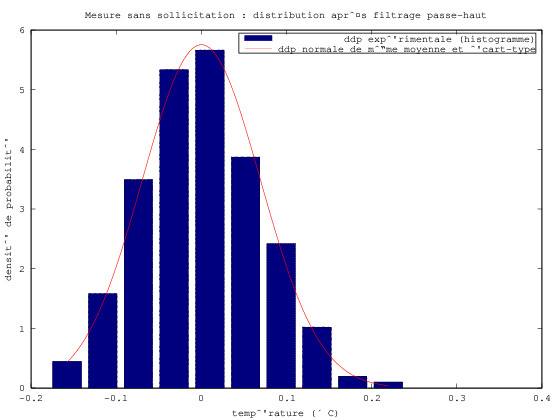

In [128]:
[p,x] = hist(yf);
p = p / trapz(x,p);

xn = linspace(min(x),max(x));
pn = normpdf(xn, muy, sigmay);

bar(x,p); hold on; plot(xn,pn,'r'); hold off
title('Mesure sans sollicitation : distribution après filtrage passe-haut')
xlabel('température (°C)')
ylabel('densité de probabilité')
legend('ddp expérimentale (histogramme)', 'ddp normale de même moyenne et écart-type')

# Analyser la partie déterministe d’un signal et l’échantillonner

## Obtention d’un signal de mesure avec sollicitation de l’actionneur

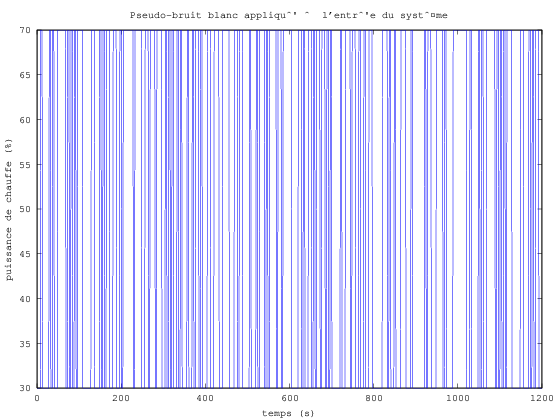

In [129]:
X = signalgen('sbpa',0.25/0.5,1200,[30 70]);

plot(X)
title('Pseudo-bruit blanc appliqué à l''entrée du système')
xlabel('temps (s)')
ylabel('puissance de chauffe (%)')

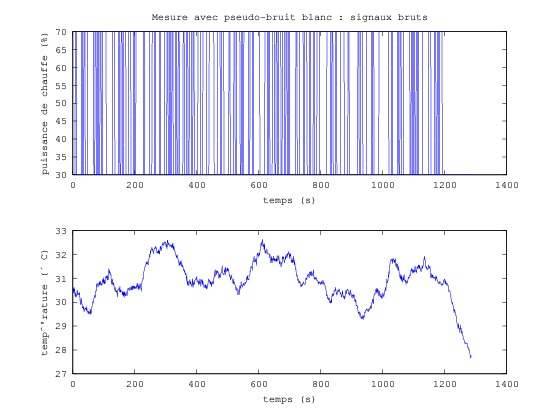

In [130]:
data = load('pseudobruitblanc.txt');
t = data(:,1);
u = data(:,3);
y = data(:,6);
subplot(2,1,1)
plot(t,u)
title('Mesure avec pseudo-bruit blanc : signaux bruts')
xlabel('temps (s)')
ylabel('puissance de chauffe (%)')
subplot(2,1,2)
plot(t,y)
xlabel('temps (s)')
ylabel('température (°C)')

## Estimation de la fréquence maximum du signal de mesure

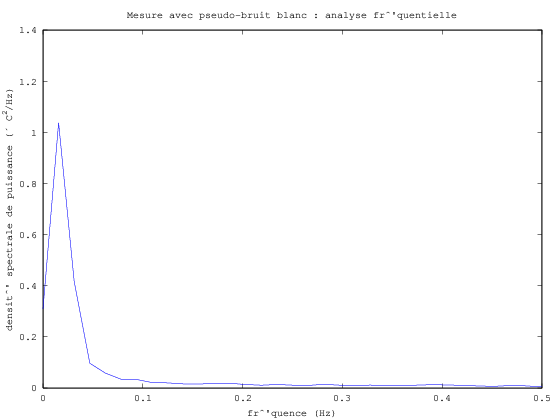

In [131]:
pwelch(y,[],[],[],1,'linear')
title('Mesure avec pseudo-bruit blanc : analyse fréquentielle')
xlabel('fréquence (Hz)')
ylabel('densité spectrale de puissance (°C^2/Hz)')

In [132]:
fmax = 0.05; % Hz

## Détermination d’une fréquence d’échantillonnage adéquate

In [133]:
fs = 4*fmax;
Te = round(1/fs);
fs = 1/Te;
fc = fs/2;

In [134]:
printf('Te = %.3g s\n', Te)
printf('fs = %.3g s\n', fs)
printf('fc = %.3g s\n', fc)

Te = 5 s
fs = 0.2 s
fc = 0.1 s


# Traiter un signal en temps réel

## Comparaison de filtres passe-bas d’ordres différents

In [135]:
[B1,A1] = butter(1,fmax/0.5);
[B8,A8] = butter(8,fmax/0.5);

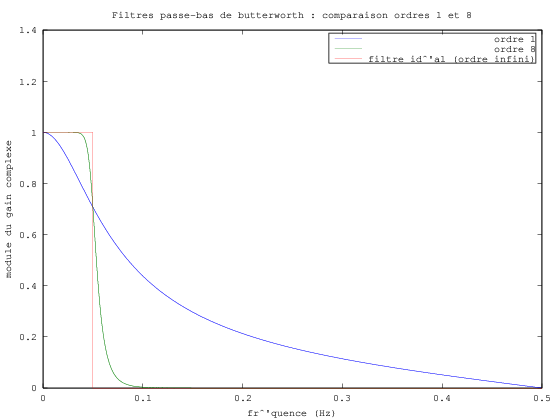

In [136]:
[H1,f1] = freqz(B1,A1,[],1);
[H8,f8] = freqz(B8,A8,[],1);
plot(f1,abs(H1), f8,abs(H8), [0 fmax fmax 0.5],[1 1 0 0])
title('Filtres passe-bas de butterworth : comparaison ordres 1 et 8')
xlabel('fréquence (Hz)')
ylabel('module du gain complexe')
legend('ordre 1', 'ordre 8', 'filtre idéal (ordre infini)')

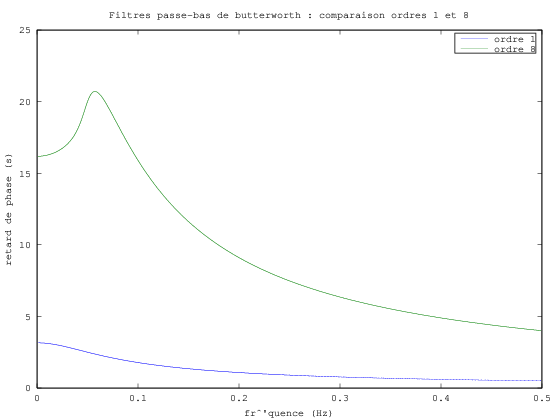

In [137]:
plot(f1,-angle(H1)./(2*pi*f1), f8,unwrap(-angle(H8))./(2*pi*f1))
title('Filtres passe-bas de butterworth : comparaison ordres 1 et 8')
xlabel('fréquence (Hz)')
ylabel('retard de phase (s)')
legend('ordre 1', 'ordre 8')

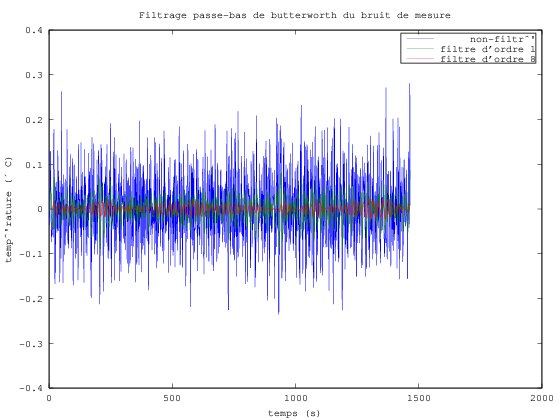

In [138]:
load('bruit_de_mesure.mat');
bruit = Yfiltre;
bruitf1 = filter(B1,A1,bruit);
bruitf8 = filter(B8,A8,bruit);
plot([bruit,bruitf1,bruitf8])
title('Filtrage passe-bas de butterworth du bruit de mesure')
xlabel('temps (s)')
ylabel('température (°C)')
legend('non-filtré','filtre d''ordre 1', 'filtre d''ordre 8')

In [139]:
sigmay = std(bruit);
sigmay1 = std(bruitf1);
sigmay8 = std(bruitf8);

In [140]:
printf('écart-type bruit de mesure = %.3g °C\n', sigmay)
printf('écart-type après filtrage ordre 1 = %.3g °C\n', sigmay1)
printf('écart-type après filtrage ordre 8 = %.3g °C\n', sigmay8)

écart-type bruit de mesure = 0.0798 °C
écart-type après filtrage ordre 1 = 0.0261 °C
écart-type après filtrage ordre 8 = 0.00817 °C


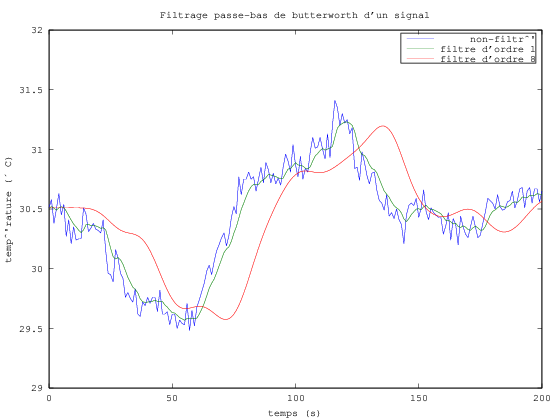

In [141]:
data = load('pseudobruitblanc.txt');
t = data(:,1);
repsbpa = data(:,6);
repsbpaf1 = filter(B1,A1,repsbpa-repsbpa(1)) + repsbpa(1);
repsbpaf8 = filter(B8,A8,repsbpa-repsbpa(1)) + repsbpa(1);
plot(t,repsbpa,t,repsbpaf1,t,repsbpaf8)
xlim([0,200])
ylim([29,32])
title('Filtrage passe-bas de butterworth d''un signal')
xlabel('temps (s)')
ylabel('température (°C)')
legend('non-filtré','filtre d''ordre 1', 'filtre d''ordre 8')

In [142]:
gs = sum(B1)/sum(A1);
p = roots(A1);
p = roots(B1);

In [143]:
printf('Gain statique = %.3g\n', gs)
printf('Zéros = %.3g\n', z)
printf('Pôles = %.3g\n', p)

Gain statique = 1
Zéros = -1
Pôles = -1


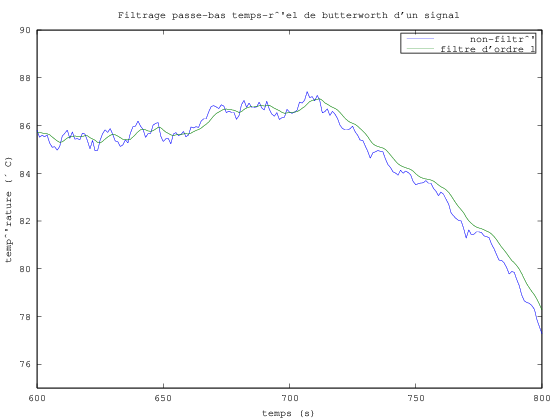

In [144]:
data = load('reponsesindicielles.txt');
t = data(:,1);
rep = data(:,5);
repf = data(:,6);
plot(t,rep,t,repf)
xlim([600,800])
ylim([75,90])
title('Filtrage passe-bas temps-réel de butterworth d''un signal')
xlabel('temps (s)')
ylabel('température (°C)')
legend('non-filtré','filtre d''ordre 1')